In [1]:
# Import the necessary libraries for reading and working with the data
import json
import numpy as np
import pandas as pd

# Import matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Import datetime
import datetime

In [2]:
# Import the login files
login_df = pd.read_json('logins.json')

# # Import the ultimate_data_challenge files
# challenge_df = pd.read_json('ultimate_data_challenge.json', orient='records')

It appears as if there is an error with loading in the data. I'll take a different approach. First I'll load the json file into the notebook. Then I'll convert that to a dataframe. Let's see how that goes.

In [3]:
login_df.shape

(93142, 1)

In [4]:
# Open a connection to the json file for reading
challenge_file = open('ultimate_data_challenge.json', mode='r')

# Read the json file
challenge_json = challenge_file.read()

# Close the connection
challenge_file.close()

# # Decode the json file
challenge_data = json.loads(challenge_json)

# # Convert the decoded json file to a dataframe
challenge_df = pd.DataFrame(challenge_data)

In [5]:
challenge_df.shape

(50000, 12)

### Part 1 ‑ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [6]:
# Take a look at the summary statistics for the logins
login_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


It appears that the first and last entries are at 1970-01-01 20:12:16 and 1970-04-13 18:57:18 (YYYY-MM-DD H:m:s). Besides the login_time, there are no additional columns. As a result, I don't believe there are any issues with data quality here (no null values or outliers). 

Before I resample the dataset to 15minute intervals, I will create an additional column to count the data. Then I will assign the index to the datetime series for resampling

In [7]:
# Define an additional column and fill with 1's
login_df['counts'] = 1 

# Set the login_time column as the index
login_df.set_index('login_time', inplace=True)

In [8]:
# Resample the data
grouped_login = login_df.resample('15T').sum()

In [9]:
# Take a look at the head of the resampled logins
grouped_login.head()

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [10]:
grouped_login.shape

(9788, 1)

Everything looks good so far. Next I'll begin to plot the time-series. Since the resulting resample data has 9788 entries, it would be impractical to plot all the points on a single plot. I'll break this down to smaller segments.

1. Monthly
2. Weekly data (resample to weekly)
3. Barplot of each day
4. Hourly

In [11]:
# Resample the data to monthly
month_login = login_df.resample('1M', label='left').sum()

In [12]:
# Show the result.
month_login

,counts
login_time,
1969-12-31,21239
1970-01-31,24673
1970-02-28,33723
1970-03-31,13507


Even without visualizations, there is a visible increase in login counts in March. The drop in login counts seen in April is likely due to the last data point being mid-April. Let's explore these months a little.

In [13]:
# First let's resample the data to daily
daily_login = login_df.resample('1D').sum()

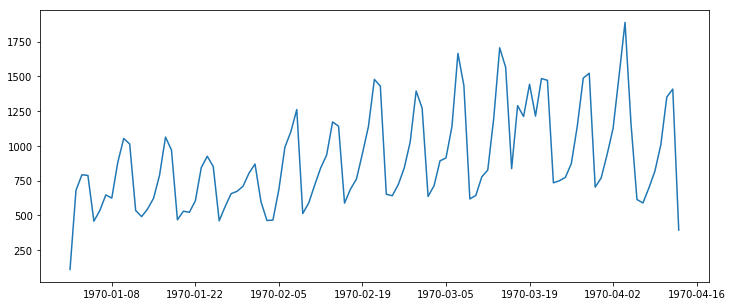

In [14]:
# Plot the daily data
plt.figure(figsize=(12,5))
plt.plot(daily_login)

Considering that there are only 3.5 months of data and there are 15 peaks, there are some sort of cyclical trend in each month.

In [15]:
# Define a dataframe for each month

# Define the dataframe for Janurary
jan_logins = daily_login[daily_login.index.month == 1]

# Define the dataframe for February
feb_logins = daily_login[daily_login.index.month == 2]

# Define the dataframe for March
mar_logins = daily_login[daily_login.index.month == 3]

# Define the dataframe for April
apr_logins = daily_login[daily_login.index.month == 4]

month_list = [jan_logins, feb_logins, mar_logins, apr_logins]

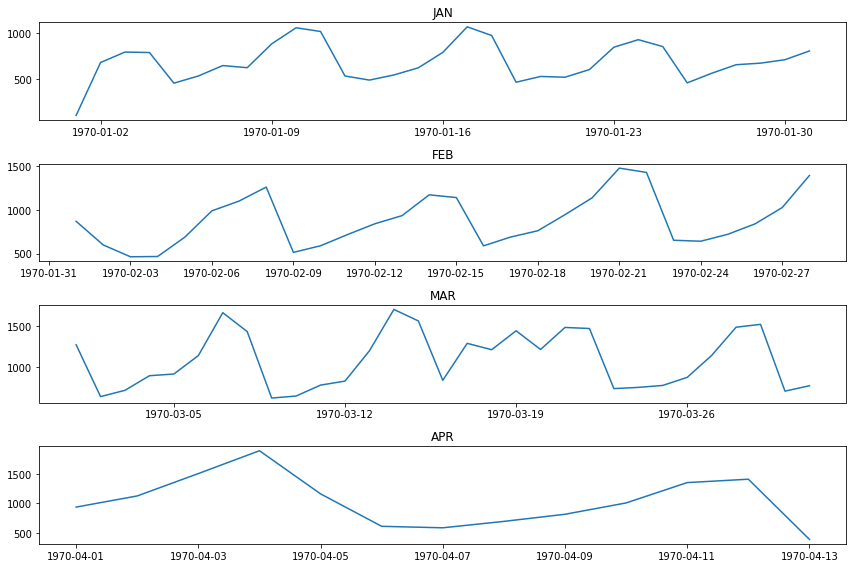

In [16]:
# Plot the data for each month

MONTHS = ['JAN', 'FEB', 'MAR', 'APR']

fig, ax = plt.subplots(nrows=4, figsize=(12, 8))

for index in range(len(month_list)):
    ax[index].plot(month_list[index])
    ax[index].set_title(MONTHS[index])
    
plt.tight_layout()

### Notable Observations:

1. Each month (excluding Apr.) has a least 3 peaks
2. The total count of logins each month is progressively increasing
3. The peaks appear to occur around the same time each month, but there is no specific date that it occurs.
4. Upon closer inspection, it appears as if each peak occurs (rises and drops) within the week.

I will confirm the 4th observation by resampling the data to weekly. If the peaks are constrained within each week, the weeks should have relatively equal login counts.

In [17]:
# Resample the data to weekly
weekly_login = login_df.resample('W').sum()

In [18]:
# Verify that the resampling occured properly
weekly_login.head()

,counts
login_time,
1970-01-04,2374
1970-01-11,5217
1970-01-18,5023
1970-01-25,4751
1970-02-01,4744


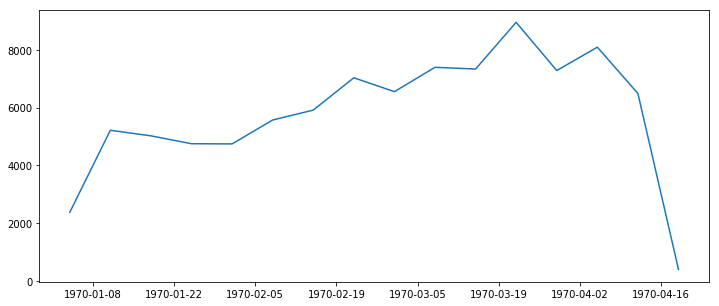

In [19]:
# Let's plot the weekly data.
plt.figure(figsize=(12, 5))
plt.plot(weekly_login)

### Noteable Observations:

1. There isn't any real peaking until mid-late March.
2. The logins are progressively increasing each week.

Unfortunately, I can't confirm if the peak occurs within each week with this visualization. To address that, I'll create a barplot of each day of the week.

In [20]:
# Work with the daily data and extract day of the week
week_of_day = daily_login.reset_index().copy()

In [21]:
# Define a column to hold the day of the week
week_of_day['day'] = week_of_day['login_time'].dt.dayofweek

# Display a week's worth of data
week_of_day.head(7)

,login_time,counts,day
0,1970-01-01,112,3
1,1970-01-02,681,4
2,1970-01-03,793,5
3,1970-01-04,788,6
4,1970-01-05,459,0
5,1970-01-06,536,1
6,1970-01-07,648,2


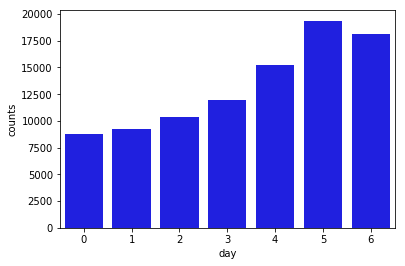

In [22]:
# Groupby the day of the week
grouped_week = week_of_day.groupby('day').sum()

# # Plot the data on a barplot
# plt.figure(figsize=(10, 5))
sns.barplot(x = grouped_week.index, y=grouped_week['counts'], color='b')

Given that Monday = 0 and Sunday = 6, it appears as if the logins peak from Friday to Sunday. This makes intuitive sense as weekdays are workdays and usually have less online traffic.

An hourly analysis may help confirm the weekday/workday assumption.

In [23]:
# Resample the original data to hourly
hourly_login = login_df.resample('H').sum().reset_index()

# View the first 24 hrs
hourly_login.head(24)

,login_time,counts
0,1970-01-01 20:00:00,24
1,1970-01-01 21:00:00,9
2,1970-01-01 22:00:00,21
3,1970-01-01 23:00:00,58
4,1970-01-02 00:00:00,53
5,1970-01-02 01:00:00,33
6,1970-01-02 02:00:00,43
7,1970-01-02 03:00:00,28
8,1970-01-02 04:00:00,9
9,1970-01-02 05:00:00,11


In [24]:
# Define a column to hold the hour the day
hourly_login['hour'] = hourly_login['login_time'].dt.hour

# Define a column for day of the week
hourly_login['day'] = hourly_login['login_time'].dt.dayofweek

In [25]:
# Groupby the day and hour for plotting
grouped_hourly = hourly_login.groupby(['day', 'hour']).sum().reset_index()

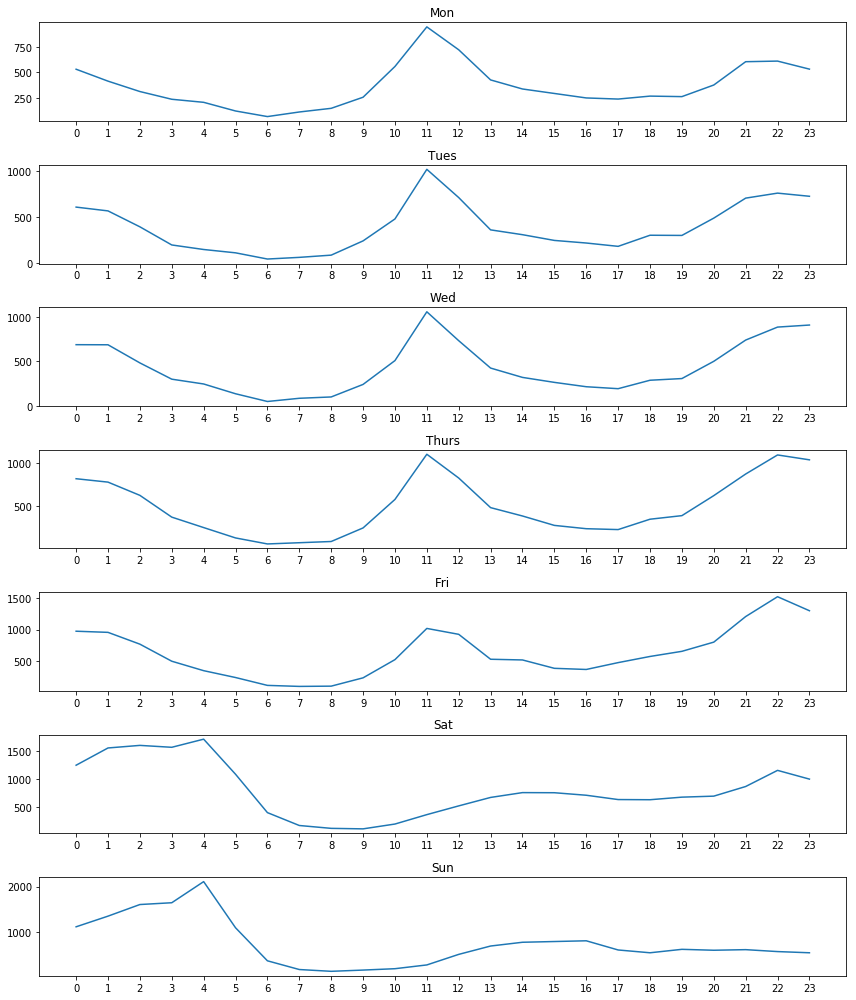

In [26]:
DAYS_OF_WEEK = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']

# Define the figure for plotting 
fig, ax = plt.subplots(nrows=7, figsize=(12, 14))

# Iterate over the days of the week
for i in range(7):
    ax[i].plot(grouped_hourly.loc[grouped_hourly['day'] == i, ['hour', 'counts']].set_index('hour'))
    ax[i].set_title(DAYS_OF_WEEK[i])
    ax[i].set_xticks(np.arange(24))
    
plt.tight_layout()

# Plot all the days on a single plot

# plt.figure(figsize=(12, 10))

# for i in range(7):
#     plt.plot(grouped_hourly.loc[grouped_hourly['day'] == i, ['hour', 'counts']].set_index('hour'))
    
# plt.legend(np.arange(7))

### Notable Observations

1. Monday through Friday have similar trends. There is a surge of activity around lunch time (12PM) and late evening (10PM). Activity is also at its lowest at 7AM. 
2. For Saturdya and Sunday, they have their own trends with peak activity at 5AM, lowest activity around 9AM, and leveled throughout.
3. Monday overall has lower activity whereas Friday - Sunday have highest activity (see y-axis scale). 

With these plots, it does seem that weekdays/workdays have significant different activties compared to the weekends.

## Conclusion:

1. The login count is showing progressive growth.
2. There are weekly trends in login activity, particular with the highs from Friday to Sunday and lows from Monday to Thursday.
3. Within the weekday, there is increased activity around noon (12PM) and late evening (10PM). TThe activity carries over to very early morning the next day (2AM). Lowest activity occurs at 7AM.
4. On the weekends, there are large amounts of activity starting from the start of the day until 5AM where it peaks and starts to decline. It reaches its lowest at 9AM and levels to around the average for the remaidner of the day.

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Personal Notes:
1. Driver partners are basically taxi drivers, Uber, Lyft, etc.

Purpose: Increase availability of driver partners in both Gotham and Metropolis.

Potential Metrics:
1. Check for increased toll activity
2. Keep track of reimbursed tolls to driver partners
3. Look for increased activity outside of normal circadian rhythms on weekdays (Gotham = more activity during the day) and (Metropolis = more activity at night). Method of measurement could be logged user or driver activity (provided by the company).

Answer #1:
Personally, I would choose to measure the success of my experiment using a feature combining the count of reimbursed tolls to driver partners and the logged driver activity (perhaps driver activity divided by reimbused tolls). I believe this form of metric is best each metric individually cannot accurately portray the effects of the experiment. The count of reimbursed tolls alone fails to take into account drivers that take advantage of the reimbursement and do not contributed as a driver partner. Increased driver activity alone fails to connect its activity to the toll bridge because it is difficult to know if the driver is going across the toll bridge. I would avoid using increased toll activity as this could overlap with background noise where there are sudden increases in toll activity due to outside circumstances. 

Answer #2:
For this experiment, I think it would be best to apply A/B Testing where half of the driver partners (randomly chosen) are offered this "deal" (experimental condition) and the other half are not (control condition). With this method, there are multiple means of comparison to observe the success (metric records for drivers before and after "deal" in experimental group and metric records of the experimental group relative to control group). Since the experiment is expecting to yield higher activity, it would be best to use a one-sided t-test. Statistical significance would support that the experiment functioned as expected where reimbursing tolls to driver partners increased their availability in both Gotham and Metropolis.

Future Recommendations:
If further increased activity is desired, I would suggest the city partner up with companies that host the driver partners to not only improve tracking records for drivers, but also to financially promote drivers driving between the cities (offer incentives).

### Part 3 ‑ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the mo

Here, I will be working with the challenge dataframe. I will start with cleaning the data before performing any EDA.

In [27]:
# Import the necessary modules for this exercise

# Modules for inferential Statistics
# Import stats from scipy
from scipy import stats


# Modules for building the model
# Import the pipeline
from sklearn.pipeline import Pipeline, FeatureUnion

# Import the preprocessing steps
from sklearn.preprocessing import LabelBinarizer, StandardScaler, FunctionTransformer

# Import train_test_split
from sklearn.model_selection import train_test_split

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import xgb
import xgboost as xgb

# Import roc_auc_score
from sklearn.metrics import roc_auc_score

In [28]:
# Print summary statistics for the dataset
challenge_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [29]:
# Print the description of the dataset
challenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Right off the bat, I can see that there are 3 columns with null values and 3 columns with potential outliers. Since the columns with null values and columns with outliers are different, I will address the null columns first.

Additionally, it appears that last_trip_date and signup_date are being read as strings and not datetime objects. I will also be converting these two columns to datetime objects

Note that there are no unique IDs for each user. This will become a problem if I perform any groupings.

In [30]:
# Take a look at the null values in avg_rating_by_driver
challenge_df[challenge_df['avg_rating_by_driver'].isnull()].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
90,6.28,NaN,5.0,1.00,Winterfell,2014-02-09,iPhone,2014-01-10,0.0,1,False,0.0
274,6.00,NaN,2.0,4.00,Astapor,2014-02-09,iPhone,2014-01-25,100.0,1,False,0.0
277,1.82,NaN,NaN,1.00,Winterfell,2014-01-26,iPhone,2014-01-25,0.0,1,False,0.0
536,1.41,NaN,5.0,1.00,Winterfell,2014-02-08,Android,2014-01-18,0.0,1,False,100.0
857,0.42,NaN,4.0,1.00,Winterfell,2014-03-16,iPhone,2014-01-11,0.0,0,False,0.0
1021,2.33,NaN,NaN,1.75,King's Landing,2014-06-13,iPhone,2014-01-23,100.0,0,True,100.0
1073,9.21,NaN,5.0,1.00,King's Landing,2014-04-27,Android,2014-01-19,0.0,0,False,0.0
1164,2.57,NaN,2.0,1.00,Winterfell,2014-01-25,Android,2014-01-24,0.0,1,True,100.0
1181,24.91,NaN,3.0,1.00,Winterfell,2014-01-25,Android,2014-01-25,0.0,1,False,0.0
1205,8.94,NaN,NaN,1.00,Winterfell,2014-02-22,Android,2014-01-18,0.0,0,False,100.0


In [31]:
# Take a look at the null values in avg_rating_of_driver
challenge_df[challenge_df['avg_rating_of_driver'].isnull()].head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6,3.95,4.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
9,2.37,5.0,NaN,1.0,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0
12,20.29,5.0,NaN,1.0,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0
14,26.01,5.0,NaN,1.0,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0
15,13.20,5.0,NaN,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0
20,2.53,3.0,NaN,1.0,Winterfell,2014-03-16,Android,2014-01-31,0.0,1,False,50.0
21,3.31,5.0,NaN,1.0,Astapor,2014-04-29,iPhone,2014-01-09,0.0,1,False,100.0
22,11.47,5.0,NaN,1.0,Winterfell,2014-05-02,iPhone,2014-01-24,0.0,0,False,100.0
25,14.48,5.0,NaN,1.0,Winterfell,2014-01-03,iPhone,2014-01-02,0.0,1,True,100.0
28,5.97,5.0,NaN,1.5,Winterfell,2014-06-08,iPhone,2014-01-19,100.0,0,False,0.0


In [32]:
# Take a look at the null values in phone
challenge_df[challenge_df['phone'].isnull()].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
134,2.88,5.0,5.0,1.00,King's Landing,2014-06-11,None,2014-01-10,0.0,0,False,100.0
176,20.32,5.0,5.0,1.00,Astapor,2014-03-18,None,2014-01-28,0.0,0,False,100.0
320,31.01,5.0,5.0,1.00,Astapor,2014-01-09,None,2014-01-08,0.0,1,False,100.0
349,6.03,5.0,3.3,1.00,Winterfell,2014-06-22,None,2014-01-06,0.0,1,True,33.3
389,3.08,4.8,4.9,1.02,King's Landing,2014-07-01,None,2014-01-26,3.0,5,False,66.7


In [33]:
challenge_df['phone'].unique()

array(['iPhone', 'Android', None], dtype=object)

For both numerical columns, there is nothing particularly odd about the rest of the entry. As a result, I think null values would represent that no rating was given. Since both columns are continuous variables, it would be incorrect to give them 0's. As a result, I think it would be best to fill the values with the median.

For the phone column, the other entries are iPhone and Android. I believe the null value in this column represents the use of other mobile operating systems. In this situation, I believe it is appropriate the fill the null value with "Other" to indicate that they are not using either operating systems.

In [34]:
# Create a copy of the challenge data
cleaned_challenge = challenge_df.copy()

# Fill the avg_rating_by_driver column with the median value
cleaned_challenge['avg_rating_by_driver'].fillna(cleaned_challenge['avg_rating_by_driver'].median(), inplace=True)

# Fill the avg_rating_of_driver column with the median value
cleaned_challenge['avg_rating_of_driver'].fillna(cleaned_challenge['avg_rating_of_driver'].median(), inplace=True)

# Fill the phone column with "Other"
cleaned_challenge['phone'].fillna('Other', inplace=True)

Let's check out the potential outliers in avg_dist, surge_pct, trips_in_first_30_days.

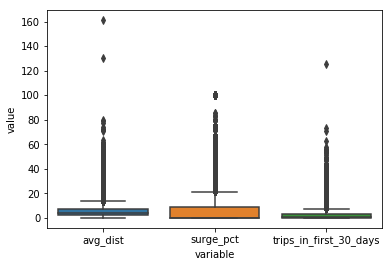

In [35]:
# Create a list for the columns with outliers
OUTLIERS = ['avg_dist', 'surge_pct', 'trips_in_first_30_days']

# Plot boxplots of the 3 columns
sns.boxplot(x="variable", y="value", data=pd.melt(cleaned_challenge[OUTLIERS]))

From the boxplot, there are quite a couple of outliers (anything outside the whiskers). However, because they are so frequent, I don't want to transform them carelessly. I'll limit by study to the extremeties in avg_dist and trips_in_first_30_days.

In [36]:
# Let's observe the outliers in avg_dist
cleaned_challenge.sort_values('avg_dist', ascending=False).head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
20701,160.96,5.0,4.9,1.0,Astapor,2014-06-26,Android,2014-01-25,0.0,0,False,100.0
534,129.89,5.0,4.9,1.0,King's Landing,2014-03-09,Other,2014-01-04,0.0,0,False,0.0
1302,79.69,5.0,5.0,1.0,Winterfell,2014-01-30,iPhone,2014-01-30,0.0,1,False,100.0
22290,79.34,5.0,5.0,1.0,Astapor,2014-06-26,iPhone,2014-01-12,0.0,0,True,100.0
47595,77.13,5.0,5.0,1.0,King's Landing,2014-06-09,iPhone,2014-01-25,0.0,0,True,0.0


In [37]:
# Let's observe the outliers in trips_in_first_30_days
cleaned_challenge.sort_values('trips_in_first_30_days', ascending=False).head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
18514,2.02,4.8,5.0,1.12,King's Landing,2014-06-30,iPhone,2014-01-02,14.4,125,True,72.0
99,2.86,4.9,4.9,1.00,Astapor,2014-03-05,Android,2014-01-27,0.0,73,True,89.7
3030,2.32,4.8,4.9,1.06,Winterfell,2014-06-28,iPhone,2014-01-06,2.9,71,True,85.9
29070,1.45,4.6,4.0,1.07,Astapor,2014-06-29,iPhone,2014-01-10,7.3,63,True,83.3
48804,2.30,4.7,4.4,1.04,Astapor,2014-06-05,iPhone,2014-01-24,3.1,58,True,77.6


For both of these columns, I will scale them down towards the rest of the group. 

avg_dist to 80

trips_in_first_30_days to 74

In [38]:
# Replace the extreme values in avg_dist with 80
cleaned_challenge.loc[cleaned_challenge['avg_dist'] > 100, 'avg_dist'] = 80

# Replace the extreme values in trips_in_first_30_days with 74
cleaned_challenge.loc[cleaned_challenge['trips_in_first_30_days'] > 100, 'trips_in_first_30_days'] = 74

In [39]:
# Let's take a look at the unique values for city
cleaned_challenge['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [40]:
# Split the dataframe into active users and inactive users

# Define the active users
active_users = cleaned_challenge[cleaned_challenge['trips_in_first_30_days'] > 0].copy()

# Define the active users
inactive_users = cleaned_challenge[cleaned_challenge['trips_in_first_30_days'] == 0].copy()

Let's convert the two date columns to proper datetime objects.

In [41]:
# Convert the dtype of last_trip_date column to datetime
cleaned_challenge['last_trip_date'] = pd.to_datetime(cleaned_challenge['last_trip_date'])

# Convert the dtype of last_trip_date column to datetime
cleaned_challenge['signup_date'] = pd.to_datetime(cleaned_challenge['signup_date'])

In [42]:
print ('Active:   ', len(active_users))
print ('Inactive: ', len(inactive_users))

Active:    34610
Inactive:  15390


Over the last couple of months, it seems approximately 30% of the users have become inactive.

Let's see if there are any visually differences between these two groups.

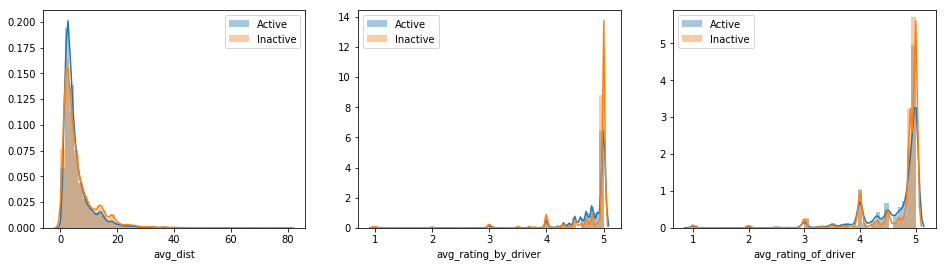

In [43]:
# Define a list with all the numerical columns
NUMERICAL = [col for col in cleaned_challenge.columns if cleaned_challenge[col].dtype == 'float64']

# Create plots for the first 3 numerical columns
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

for i in range(3):
    sns.distplot(active_users[NUMERICAL[i]], ax=ax[i], label='Active').legend()
    sns.distplot(inactive_users[NUMERICAL[i]], ax=ax[i], label='Inactive').legend()

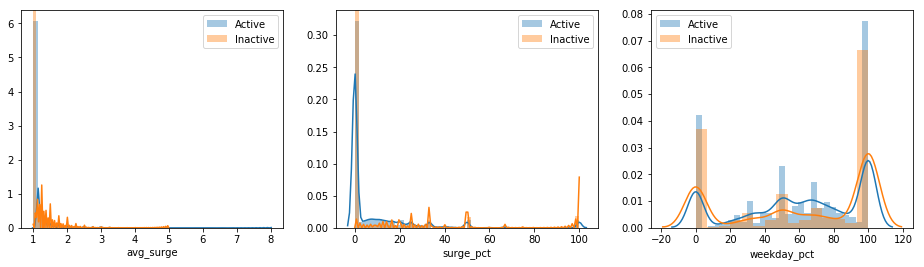

In [44]:
# Create plots for the next 3 numerical columns
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))

for i in range(3):
    sns.distplot(active_users[NUMERICAL[i+3]], ax=ax[i], label='Active').legend()
    sns.distplot(inactive_users[NUMERICAL[i+3]], ax=ax[i], label='Inactive').legend()

There doesn't seem to be any visual differences between the two groups. 

However, current active users appear to be more casual users (intermediate range for weekday_pct) than currently inactive users. This suggests that the active users use the Ultimate application on both weekdays and weekends. In both extremeties of this variable (0 usage on weekdays and 0 usage on weekends), the currently inactive users are more apparent.

Let's try some two-sided t-test and bootstrapping.

Hypothesis test for testing statistical difference between active and inactive users (p < 0.05):

Null Hypothesis: There is no difference between the two groups

Alternate Hypothesis: The two groups are statistically different.

In [45]:
# Perform the t-test on ALL the numerical columns
for col in NUMERICAL:
    t_score=stats.ttest_ind(active_users[col], inactive_users[col])
    print ('T-score for {}: {}'.format(col, t_score))

T-score for avg_dist: Ttest_indResult(statistic=-15.724791882507994, pvalue=1.3906705621186245e-55)
T-score for avg_rating_by_driver: Ttest_indResult(statistic=-4.489643639133461, pvalue=7.150162715034273e-06)
T-score for avg_rating_of_driver: Ttest_indResult(statistic=-12.399303029416846, pvalue=2.970601535329053e-35)
T-score for avg_surge: Ttest_indResult(statistic=2.3094461301357625, pvalue=0.020922892160045396)
T-score for surge_pct: Ttest_indResult(statistic=2.5144681086090093, pvalue=0.011924321064206714)
T-score for weekday_pct: Ttest_indResult(statistic=-1.5009641436435157, pvalue=0.1333711507019858)


In [46]:
for col in NUMERICAL:
    
    # Create 1000 instances in an empty array for the two groups
    active_bootstrap = np.empty (1000)
    inactive_bootstrap = np.empty (1000)
    
    # Store 1000 bootstrap samples in the empty array
    for i in range(1000):
        active_bootstrap[i] = np.mean(np.random.choice(active_users[col], len(active_users)))
        inactive_bootstrap[i] = np.mean(np.random.choice(inactive_users[col], len(inactive_users)))
        
    # Define the confidence intervals
    confidence_interval_active = np.percentile(active_bootstrap, [2.5, 97.5])
    confidence_interval_inactive = np.percentile(inactive_bootstrap, [2.5, 97.5])
    
    # Print the results
    print ('\n{}:'.format(col))
    print ('95% Confidence Interval for Active Users:', confidence_interval_active)
    print ('95% Confidence interval for Inactive Users:', confidence_interval_inactive)


avg_dist:
95% Confidence Interval for Active Users: [5.47505224 5.58300322]
95% Confidence interval for Inactive Users: [6.29330954 6.48808665]

avg_rating_by_driver:
95% Confidence Interval for Active Users: [4.76844705 4.777487  ]
95% Confidence interval for Inactive Users: [4.78502794 4.80072303]

avg_rating_of_driver:
95% Confidence Interval for Active Users: [4.62306234 4.63506862]
95% Confidence interval for Inactive Users: [4.68899172 4.70651819]

avg_surge:
95% Confidence Interval for Active Users: [1.07401992 1.07869819]
95% Confidence interval for Inactive Users: [1.06780021 1.07540583]

surge_pct:
95% Confidence Interval for Active Users: [8.7886842  9.18262142]
95% Confidence interval for Inactive Users: [8.17783252 8.82562947]

weekday_pct:
95% Confidence Interval for Active Users: [60.43704796 61.13389107]
95% Confidence interval for Inactive Users: [60.62632862 61.91016634]


According to the t-test and bootstrapping, there appears to be statistically significant  differences between the active and inactive users in all, but one numerical variable (weekday_pct).

### EDA Conclusion:

1. Of the provided dataset, approximately 30% of the users were inactive in the past month.
2. Of the numerical columns, the active and inactive users have no significant difference in their usage during the week.

Let's move onto building the model.

I'll quickly fit the data into a RandomForestClassifier to determine some feature importance.

First I'll perform some preprocessing steps and place it into a pipeline. From there, I will add different machine learning algorithms and determine which ones performed the highest. Performance will be measured via roc_auc_score which is optimal for binary classifications.

In [47]:
cleaned_challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Before I move on, let me create a target column. I will also remove the trips_in_first_30_days columns

TARGET = {0: inactive, 1: active}

Additionally, I will drop the last_trip_date since it relays the same information as the target column. I will extract additional features from the signup_date, namely week, month, and day of week.

In [48]:
# Create a copy of the cleaned_challenge
model_challenge = cleaned_challenge.copy()

In [49]:
# Create the target column
model_challenge['TARGET'] = model_challenge['trips_in_first_30_days'].apply(lambda x: 1 if x > 0 else 0)

# Create the start_week column
model_challenge['start_week'] = model_challenge['signup_date'].dt.weekofyear

# Create the start_month column
model_challenge['start_month'] = model_challenge['signup_date'].dt.month

# Create the start_weekday column
model_challenge['start_weekday'] = model_challenge['signup_date'].dt.dayofweek

# Drop the trips_in_first_30_days column
model_challenge.drop(['trips_in_first_30_days', 'last_trip_date', 'signup_date'], axis=1, inplace=True)

In [50]:
# Define the categorical columns
CATEGORICAL = [col for col in model_challenge.columns if col not in NUMERICAL]

# Remove the target column from the list
CATEGORICAL.remove('TARGET')

# Sanity check that all columns are in a list except target
assert (len(CATEGORICAL) + len(NUMERICAL) == len(model_challenge.columns) - 1)

In [51]:
# Split the data into X(variables) and y(target)
X = model_challenge.drop('TARGET', axis=1)
y = model_challenge['TARGET']

In [52]:
# Fit the numerical data to the MinMaxScaler()
NUMERICAL_X_train = StandardScaler().fit_transform(X[NUMERICAL])

# Define the numerical dataframe
NUMERICAL_df = pd.DataFrame(NUMERICAL_X_train, columns=NUMERICAL)

In [53]:
# Define the categorical dataframe
CATEGORICAL_df = X[CATEGORICAL]

# Create dummy variables for the categorical variables
for col in CATEGORICAL:
    group_dummies = pd.get_dummies(CATEGORICAL_df[col]).rename(columns=lambda x: col + str(x))
    CATEGORICAL_df = CATEGORICAL_df.join(group_dummies)
    del CATEGORICAL_df[col]

In [54]:
concat_X = pd.concat([NUMERICAL_df, CATEGORICAL_df], axis=1)

In [55]:
# Fit the converted data to the RandomForestClassifier()
rf = RandomForestClassifier().fit(concat_X, y)

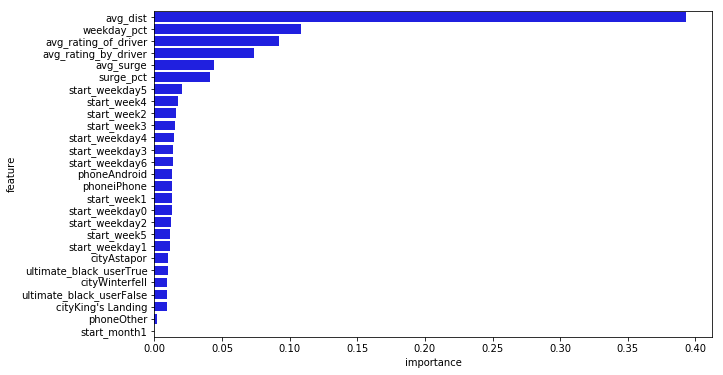

In [56]:
# Extract the feature importances and zip it with the columns into a dataframe
importances = rf.feature_importances_
features = pd.DataFrame({'feature': concat_X.columns, 'importance': importances})
features.sort_values(by='importance', ascending=False, inplace=True)

# Display a horizontal barplot with the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=features['importance'], y=features['feature'], color='blue', orient='h')

#### Feature Importance Observations:
1. avg_dist is the major predicting feature for active and inactive users. It appears that active users, on average, travel shorter distances.
2. It appears that weekday_pct is also an important feature, but I'm unsure to which direction is best.
3. surge_pct and avg_surge show suggest that currently active users will use the Ultimate application during peak hours.

In [57]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(concat_X, y, test_size=0.2)

Originally I was going to use FeatureUnion and FunctionTransformer to perform my preprocessing steps in a pipeline. However, I already completed them manually during the process of determing feature importance. As a result, I am going to use the resulting dataframe from that process to train multiple different models.

#### Logistic Regression

In [58]:
# Create the Pipeline with LogisticRegression
lr = LogisticRegression()

# Fit the Pipeline with the training data
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
# Assign the predictions to variables
predicted_train_values = lr.predict_proba(X_train)[:, -1]
predicted_test_values = lr.predict_proba(X_test)[:, -1]

# Print the scores
print (roc_auc_score(y_test, predicted_test_values))

0.5848806257985687


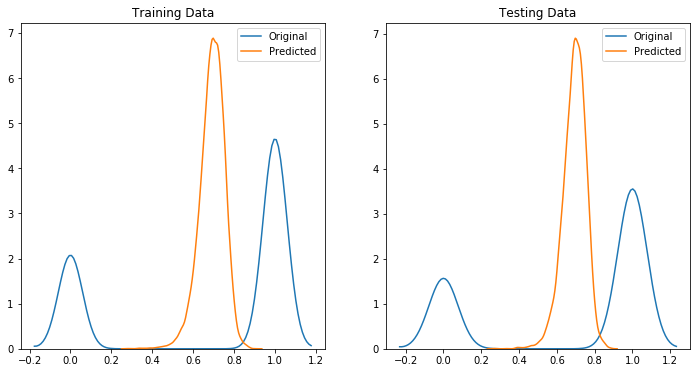

In [60]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

#### Random Forest Classifier

In [61]:
# Create the Pipeline with LogisticRegression
rf = RandomForestClassifier(n_estimators=100)

# Fit the Pipeline with the training data
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
# Assign the predictions to variables
predicted_train_values = rf.predict_proba(X_train)[:, -1]
predicted_test_values = rf.predict_proba(X_test)[:, -1]

# Print the scores
print (roc_auc_score(y_test, predicted_test_values))

0.6553755821435978


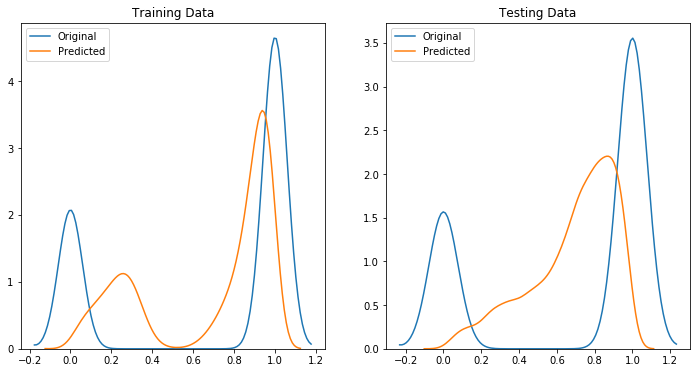

In [63]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

#### XGBClassifier

In [64]:
# Create the Pipeline with LogisticRegression
xgb = xgb.XGBClassifier()

# Fit the Pipeline with the training data
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [65]:
# Assign the predictions to variables
predicted_train_values = xgb.predict_proba(X_train)[:, -1]
predicted_test_values = xgb.predict_proba(X_test)[:, -1]

# Print the scores
print (roc_auc_score(y_test, predicted_test_values))

0.716313452963353


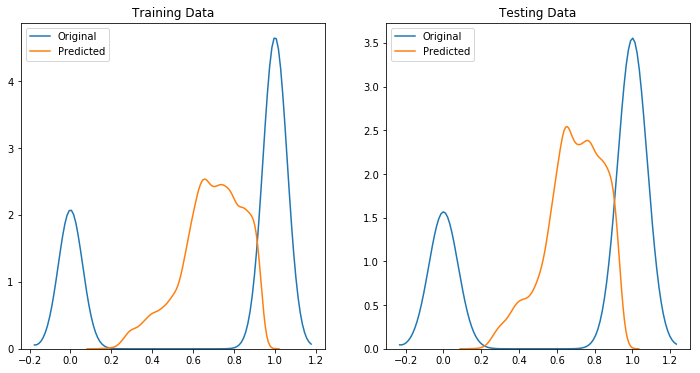

In [66]:
# Define the figure
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# Plot the training data
sns.kdeplot(y_train, ax=ax[0], label='Original').set_title('Training Data')
sns.kdeplot(predicted_train_values, ax=ax[0], label='Predicted')

# Plot the test data
sns.kdeplot(y_test, ax=ax[1], label='Original').set_title('Testing Data')
sns.kdeplot(predicted_test_values, ax=ax[1], label='Predicted')

Without spending further time on hyperparameter tuning, I will address the rest of my approach. I would discontinue the use of LogisitcRegression because the algorithm appears to make very linear predictions. I would continue with both the RandomForestClassifier and XGBClassifier. Both algorithms use base decision tree models, but they use different tuning parameters. Since a model capable of making non-linear predictions addresses the problem better, I would be cautious of higher regularization strength.

From the three attempted algorithms, XGBClassifier outperformed the rest by at least 0.5 in roc_auc_score.

My main concern lies not with the model, but with the data. From the EDA and inferential statistics performed on the data, I found the differences between the active and inactive users to be very minute. It felt like there were many columns missing, such as average trips per week, average expenses, average surge expenses, number of months with usage, etc.

I believe the main insights to take away from this model is the average distance traveled and percentage of trips during surge hours. It appears that currently active users travel shorter distances and are more likely to use the app during surge hours. An additional way to interpret this, is that currently inactive users usually only use the application when necessary to travel further distances and usually avoid using it during surge hours. 

To retain more active users, I believe Ultimate should reduce either reduce the surge hours or reduce the surge multiplier. Personally, I believe reducing the surge hours would have a stronger effect as it had a higher feature importance and users are often deterred by any form of price multiplier. Additionally, I would promote the use of Ultimate during the weekday via incentives.